# Chapter 4 Study
# Further Research on the full MNIST dataset

In [1]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Data Gathering

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [5]:
(path/'training').ls()

(#10) [Path('training/9'),Path('training/0'),Path('training/7'),Path('training/6'),Path('training/1'),Path('training/8'),Path('training/4'),Path('training/3'),Path('training/2'),Path('training/5')]

In [6]:
(path/'testing').ls()

(#10) [Path('testing/9'),Path('testing/0'),Path('testing/7'),Path('testing/6'),Path('testing/1'),Path('testing/8'),Path('testing/4'),Path('testing/3'),Path('testing/2'),Path('testing/5')]

## Peek at the data

In [7]:
threes = (path/'training'/'3').ls().sorted()

In [8]:
three_tensors = [tensor(Image.open(o)) for o in threes]

In [9]:
three_tensors[1].size()

torch.Size([28, 28])

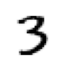

In [10]:
show_image(three_tensors[1]);

## Prepare the data

Generally, when working with floats we want the data to be between 0 and 1 thus we will divide each by 255 to do this. Moreover, we need to stack our images into a nice rank 3 tensor for our model. For example:

In [11]:
stacked_threes = torch.stack(three_tensors).float()/255

In [12]:
stacked_threes.size() # 6131 images of 28 pixel width and 28 pixel length.

torch.Size([6131, 28, 28])

In [13]:
stacked_threes.ndim # rank 3

3

In [14]:
def get_data(num, data='training'):
    nums = (path/data/num).ls().sorted()
    num_tensors = [tensor(Image.open(o)) for o in nums]
    return torch.stack(num_tensors).float()/255

In [15]:
get_data('8')[0][8:16, 8:16]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8118, 0.9922],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3294, 0.9804, 0.9804],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3098, 0.8824, 0.9882, 0.7882],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3804, 0.9882, 0.9882, 0.4745],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5804, 0.9882, 0.5569, 0.7176],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8510, 0.9882, 0.9686, 0.9922],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8549, 0.9922, 0.9922, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.2392, 0.9294, 0.9882, 0.9882, 0.9451]])

### Training set:

In [16]:
training = [get_data(str(i)) for i in range(10)]

In [17]:
train_x = torch.cat(training).view(-1, 28*28)

In [18]:
labels = []
for n, x in enumerate(training):
    labels += [n]*len(x)
train_y = tensor(labels).unsqueeze(1)

In [19]:
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [20]:
# 60000 images, 28*28 (784) pixels
# 60000 labels

In [21]:
train_x[0].shape # first digit image

torch.Size([784])

### Validation set:

In [22]:
testing = [get_data(str(i), data='testing') for i in range(10)]

In [23]:
valid_x = torch.cat(testing).view(-1, 28*28)

In [24]:
labels = []
for n, x in enumerate(testing):
    labels += [n]*len(x)
valid_y = tensor(labels).unsqueeze(1)

In [25]:
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [26]:
# valid_x: 10000 images, 28*28 (784) pixels
# valid_y: 10000 labels

Emulating the PyTorch dataset:

In [28]:
train_dset = list(zip(train_x,train_y))
valid_dset = list(zip(valid_x,valid_y))

## Training

In [35]:
dl = DataLoader(train_dset, batch_size=256)
xb,yb = first(dl) # Take a sample for example
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [36]:
valid_dl = DataLoader(valid_dset, batch_size=256)

### 1. Initialise weights

In [460]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [461]:
weights = init_params((28*28,10))
bias = init_params(10)

In [462]:
weights, bias

(tensor([[ 0.0342, -0.4174,  1.6537,  ...,  2.6324, -0.8313, -0.0899],
         [-3.1966,  1.5680,  0.6664,  ...,  0.5375,  0.7464, -0.6315],
         [-0.6763, -1.0859, -0.0695,  ..., -0.0945, -0.5653,  0.5952],
         ...,
         [-0.6856,  0.3372, -0.2091,  ..., -0.3588,  0.3843, -2.8089],
         [ 0.1603,  0.1264,  0.3964,  ...,  0.1280,  0.3844,  0.5591],
         [-1.1435, -2.2296,  0.4682,  ..., -0.2936, -0.1988, -1.2676]], requires_grad=True),
 tensor([-0.4231,  0.2452, -0.7060, -1.6251, -0.6217,  0.3191, -0.0889,  2.3983,  1.4903,  0.6836], requires_grad=True))

### 2. Make predictions

In [463]:
batch_x, batch_y = xb[:4], yb[:4]
batch_x.shape, batch_y.shape

(torch.Size([4, 784]), torch.Size([4, 1]))

#### Out of the box with Torch

In [464]:
t_linear = nn.Linear(784, 10, bias=True)

In [465]:
t_linear.weight.shape, t_linear.weight.mean(), t_linear.bias

(torch.Size([10, 784]),
 tensor(-0.0001, grad_fn=<MeanBackward0>),
 Parameter containing:
 tensor([-0.0166,  0.0081,  0.0302,  0.0149,  0.0028,  0.0105, -0.0246,  0.0174, -0.0041,  0.0193], requires_grad=True))

In [466]:
t_output = t_linear(batch_x)
t_output.shape

torch.Size([4, 10])

In [467]:
t_output[0]

tensor([ 0.3060, -0.4787, -0.0137,  0.1627, -0.2323,  0.1287,  0.2014,  0.0201, -0.1759,  0.1103], grad_fn=<SelectBackward>)

In [468]:
t_preds = torch.argmax(t_output, dim=1)
t_preds.shape

torch.Size([4])

Predicted: 6
Actual: 0


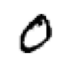

In [469]:
print(f'Predicted: {preds[0]}')
print(f'Actual: {batch_y[0].item()}')
show_image(batch[0].view(-1, 28, 28));

#### Linear layer from scratch

In [470]:
def linear1(xb): return xb@weights + bias

In [471]:
output = linear1(batch_x)
output.shape

torch.Size([4, 10])

In [472]:
preds = torch.argmax(output, dim=1)
preds.shape

torch.Size([4])

Predicted: 9
Actual: 0


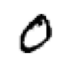

In [473]:
print(f'Predicted: {preds[0]}')
print(f'Actual: {batch_y[0].item()}')
show_image(batch_x[0].view(-1, 28, 28));

### 3. Calculate the loss

In [474]:
# Softmax + NLL Loss is the way to go when it comes to having more than two classes.

In [479]:
sm_acts = torch.softmax(t_output, dim=1) # using PyTorch
sm_acts.shape

torch.Size([4, 10])

In [480]:
sm_acts[0]

tensor([0.1322, 0.0603, 0.0961, 0.1146, 0.0772, 0.1108, 0.1191, 0.0994, 0.0817, 0.1087], grad_fn=<SelectBackward>)

In [477]:
from torch import exp
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True) # 

In [481]:
my_sm_acts = softmax(t_output)
my_sm_acts.shape

torch.Size([4, 10])

In [482]:
c_sm_acts[0]

tensor([0.1285, 0.1164, 0.0767, 0.0981, 0.1051, 0.1139, 0.0915, 0.0796, 0.0917, 0.0985], grad_fn=<SelectBackward>)

In [483]:
torch.sum(sm_acts, dim=1) 
# Softmax produces a probability for each class with all activations adding to 1 for each input.

tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [484]:
targ = batch_y.squeeze()
F.nll_loss(sm_acts, targ, reduction='none') 
# However, this is misleading given that Torch doesn't take the log for you.
# Instead to do softmax, and true NLL, we use CrossEntropyLoss.

tensor([-0.1322, -0.1110, -0.1101, -0.1245], grad_fn=<NllLossBackward>)

In [485]:
# NLL Loss is misleading in Torch with it not actually taking the log like we need. Instead,
# CrossEntropyLoss takes scare of all the steps for us.

In [486]:
loss_func = nn.CrossEntropyLoss()

In [487]:
loss = loss_func(sm_acts, targ)
loss

tensor(2.2833, grad_fn=<NllLossBackward>)

### 4. Calculate the gradient

In [488]:
loss.backward()
# weights.grad.shape, weights.grad.mean(), bias.grad

In [489]:
t_linear.weight.grad.shape, t_linear.weight.grad.mean(), t_linear.bias.grad

(torch.Size([10, 784]),
 tensor(-7.1275e-11),
 tensor([-0.1049,  0.0085,  0.0131,  0.0139,  0.0081,  0.0136,  0.0113,  0.0122,  0.0103,  0.0139]))

In [490]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()

In [491]:
calc_grad(batch_x, targ, t_linear)
t_linear.weight.grad.shape, t_linear.weight.grad.mean(), t_linear.bias.grad

(torch.Size([10, 784]),
 tensor(-4.8657e-10),
 tensor([-0.9855,  0.0817,  0.1224,  0.1288,  0.0778,  0.1268,  0.1054,  0.1150,  0.0983,  0.1294]))

In [492]:
# Opps the gradient have changed because we have cleared them from the last pass.
calc_grad(batch_x, targ, t_linear)
t_linear.weight.grad.shape, t_linear.weight.grad.mean(), t_linear.bias.grad

(torch.Size([10, 784]),
 tensor(-2.9194e-09),
 tensor([-1.8660,  0.1548,  0.2318,  0.2437,  0.1474,  0.2400,  0.1995,  0.2178,  0.1863,  0.2449]))

### 5. Step the weights

Putting it all together.

In [493]:
t_linear.weight.data -= t_linear.weight.grad * 0.0001
t_linear.bias.data -= t_linear.bias.grad * 0.0001

In [494]:
t_linear.weight.grad.zero_()
t_linear.bias.grad.zero_();

In [399]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        # step the weights
        model.weight.data -= t_linear.weight.grad * 0.0001
        model.bias.data -= t_linear.bias.grad * 0.0001
        model.grad.zero_()

To ensure we don't update any lingering gradients between batches, we need to zero out the currently stored gradients before we move on to the next batch.

### 6. & 7. Repeat until you want to stop

Woohoo!